**Importing libraries**

In [145]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.optimize import curve_fit
from lmfit.models import LinearModel
from lmfit import Parameters

**Capturing name of the PC**

In [3]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [123]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if PC_name_str == 'science12':
    cores = 84        
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

science12
84


**Defining constants**

In [5]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [6]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [7]:

z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
df_gal.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],m_gas[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,93097.000000,93097.000000,93097.000000,9.309700e+04,9.309700e+04,93097.000000,93097.000000,93097.000000
mean,325576.133087,322500.028738,320613.762863,3.993206e+11,1.326202e+12,0.763965,0.349477,-0.509183
std,184863.273960,182799.587421,183249.915097,3.995129e+11,2.955465e+12,351.345586,343.572230,328.125457
min,1.864417,10.164207,0.260974,1.800010e+11,0.000000e+00,-2896.388700,-2323.086700,-2275.444800
25%,163866.950000,166201.380000,162514.560000,2.161480e+11,2.976010e+11,-219.363920,-215.157970,-201.740720
50%,332449.620000,329260.160000,319925.780000,2.784900e+11,5.810010e+11,-2.822351,2.646382,-3.028148
75%,483949.000000,475466.120000,478698.410000,4.192930e+11,1.244070e+12,216.770710,214.257250,200.506210
max,639996.190000,639980.940000,639993.120000,1.077460e+13,1.420090e+14,2423.330800,3048.129900,2638.449000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for galaxies**

In [8]:
df_gal_temp = df_gal.copy()

df_gal_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_gal_temp['x[kpc/h]'] = df_gal['x[kpc/h]'] + (640000 * i)
            df_gal_temp['y[kpc/h]'] = df_gal['y[kpc/h]'] + (640000 * j)
            df_gal_temp['z[kpc/h]'] = df_gal['z[kpc/h]'] + (640000 * k)

            df_gal_big = df_gal_big.append(df_gal_temp)

df_gal_big.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],m_gas[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06
mean,9.655761e+05,9.625000e+05,9.606138e+05,3.993206e+11,1.326202e+12,7.639653e-01,3.494774e-01,-5.091831e-01
std,5.542931e+05,5.536083e+05,5.537571e+05,3.995109e+11,2.955449e+12,3.513438e+02,3.435705e+02,3.281238e+02
min,1.864417e+00,1.016421e+01,2.609741e-01,1.800010e+11,0.000000e+00,-2.896389e+03,-2.323087e+03,-2.275445e+03
25%,4.839490e+05,4.754661e+05,4.786984e+05,2.161480e+11,2.976010e+11,-2.193639e+02,-2.151580e+02,-2.017407e+02
50%,9.724496e+05,9.692602e+05,9.599258e+05,2.784900e+11,5.810010e+11,-2.822351e+00,2.646382e+00,-3.028148e+00
75%,1.443867e+06,1.446201e+06,1.442515e+06,4.192930e+11,1.244070e+12,2.167707e+02,2.142572e+02,2.005062e+02
max,1.919996e+06,1.919981e+06,1.919993e+06,1.077460e+13,1.420090e+14,2.423331e+03,3.048130e+03,2.638449e+03


**Reading clusters dataset**

In [9]:
df_clusters_orig = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

df_clusters_orig.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6080.000000,6080.000000,6080.000000,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,326416.401838,322055.402286,321308.240244,6.356245e+13,2.109102,-1.647297,-4.296055
std,186021.550694,182650.899538,183665.854310,4.851698e+13,316.064539,306.226537,286.454388
min,19.163288,152.653880,87.370949,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,160978.575000,164793.430000,161863.925000,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,338884.565000,333274.345000,322110.075000,4.801630e+13,-3.619450,1.969450,-8.055475
75%,486227.747500,473556.765000,478893.610000,6.945502e+13,206.816750,207.755750,181.532000
max,639887.560000,639933.380000,639848.380000,7.438200e+14,1197.640000,1164.960000,1201.260000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for clusters**

In [10]:
df_clusters_temp = df_clusters_orig.copy()

df_clusters_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_clusters_temp['x[kpc/h]'] = df_clusters_orig['x[kpc/h]'] + (640000 * i)
            df_clusters_temp['y[kpc/h]'] = df_clusters_orig['y[kpc/h]'] + (640000 * j)
            df_clusters_temp['z[kpc/h]'] = df_clusters_orig['z[kpc/h]'] + (640000 * k)

            df_clusters_big = df_clusters_big.append(df_clusters_temp)

df_clusters_big.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,1.641600e+05,1.641600e+05,1.641600e+05,1.641600e+05,164160.000000,164160.000000,164160.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,5.546773e+05,5.535561e+05,5.538918e+05,4.851314e+13,316.039508,306.202286,286.431703
min,1.916329e+01,1.526539e+02,8.737095e+01,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,4.863366e+05,4.736062e+05,4.789278e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.440918e+06,1.444771e+06,1.441655e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.919888e+06,1.919933e+06,1.919848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Extracting clusters present in central region from 640 h$^{-1}$Mpc to 1280 h$^{-1}$Mpc**

In [11]:
low_bound = 640000
upp_bound = 640000 * 2  #128000

df_clusters_center = df_clusters_big[(df_clusters_big['x[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['x[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['y[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['y[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['z[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['z[kpc/h]'] < upp_bound)]

df_clusters_center.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6.080000e+03,6.080000e+03,6.080000e+03,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,1.860216e+05,1.826509e+05,1.836659e+05,4.851698e+13,316.064539,306.226537,286.454388
min,6.400192e+05,6.401527e+05,6.400874e+05,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,8.009786e+05,8.047934e+05,8.018639e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.126228e+06,1.113557e+06,1.118894e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.279888e+06,1.279933e+06,1.279848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Adding galaxy pads at the edges of central cluster region**

In [12]:

def edge_pads_adder(clus_cube_size):
       
    low_bound =  640000    - (clus_cube_size//2)
    upp_bound = (640000*2) + (clus_cube_size//2)
    
#     print(low_bound, upp_bound)
    
    df_gal_padded = df_gal_big[(df_gal_big['x[kpc/h]'] >= low_bound) & 
                               (df_gal_big['x[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['y[kpc/h]'] >= low_bound) & 
                               (df_gal_big['y[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['z[kpc/h]'] >= low_bound) & 
                               (df_gal_big['z[kpc/h]'] <= upp_bound)]
            
    return df_gal_padded
    

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [13]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.5938062370014


2.380620866668027

In [23]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

**Calculating mean density of the simulation box for Eq. 1**

In [14]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal_big.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    sim_box_size = 640000 * 3
    gals_in_cell = np.zeros((sim_box_size//cell_size, sim_box_size//cell_size, sim_box_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    delta_gal_mean = np.mean(gals_in_cell)
    
    return delta_gal_mean

**Calculating Overdensity field for Eq. 1**

In [25]:
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

def overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, clus_cube_size, df_gal_padded):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal_padded[(df_gal_padded['x[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                  (df_gal_padded['x[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x - clus_cube_size//2)
    df_gal_cube['y[kpc/h]'] -= (clus_y - clus_cube_size//2)
    df_gal_cube['z[kpc/h]'] -= (clus_z - clus_cube_size//2)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
    
    delta_gal_error = gals_in_cell_avg_err/delta_gal_mean  
    
    #smoothing the overdensity of galaxies
#     delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [16]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [26]:
def clus_velocity_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, vel_terms, sigma_in_pix, 
                       clus_cube_size, df_gal_padded):
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, 
                                          clus_cube_size, df_gal_padded)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(h*1e3)) / denom
    
    dist = np.cbrt(denom)
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


**Calculating sigma for smoothing**

In [18]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

In [153]:
def lmfit_func(x_values, y_values, errors):
    model = LinearModel()
    
    fit_params = model.guess(y_values, x = x_values)
    fit_params['intercept'].set(value = 0, vary = False)
    
    result = model.fit(y_values, 
                       params = fit_params, 
                       x = x_values, weights = 1/errors)
    
    print(result.fit_report())
    

    return result  

param_x_lmfit = lmfit_func(df_clusters_est_err['vx[km/s]'], 
                           df_clusters_est_err['vx_est[km/s]'], 
                           df_clusters_est_err['vx_est_err[km/s]'])

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 6080
    # variables        = 1
    chi-square         = 2976.67967
    reduced chi-square = 0.48966601
    Akaike info crit   = -4340.31302
    Bayesian info crit = -4333.60026
[[Variables]]
    slope:      0.77637075 +/- 0.00566807 (0.73%) (init = 0.7911752)
    intercept:  0 (fixed)


**Plotting the scatter plots & histograms for assesment of velocity estimates**

In [27]:
def plotting_func_temp(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi, figsize = (10,12), facecolor=(1, 1, 1))

    plt.subplot(3,2,1)
    plt.scatter(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
    low_lim, high_lim = -2000, 2000
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vx - scatter plot')
    x_pos_text = 0.45
    plt.text(x_pos_text, 0.18, f'Clusters: {len(df_clusters_est_err)}', transform=plt.gca().transAxes)
    
#     fit = np.polyfit(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], 1)
#     fit_func = np.poly1d(fit)
    
    x_range = np.arange(low_lim, high_lim+1, 5)    
    def fit_func(x, m, c):
        return m*x + c
    
    param, cov = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])
    
    plt.text(x_pos_text, 0.12, f'Slope: {param[0].round(2)}', transform=plt.gca().transAxes)
    plt.text(x_pos_text, 0.06, f'Zero point: {param[1].round(2)} km/s', transform=plt.gca().transAxes)
    
    plt.plot(x_range, fit_func(x_range, *param), label = 'Linear fit', c = 'C2')
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend()

    plt.subplot(3,2,2)
#     error_x = df_clusters_est_err['vx[km/s]'] - df_clusters_est_err['vx_est[km/s]']
    plt.hist(df_clusters_est_err['vx_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{x, estimated}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    minus_one = {-1}
    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f"Mean: {round(np.mean(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f"SD: {round(np.std(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
    r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes)

    plt.title('Distribution of V$_{\mathrm{x, estimated}}$')




    plt.subplot(3,2,3)
    plt.scatter(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vy - scatter plot')
    plt.text(x_pos_text, 0.18, f'Clusters: {len(df_clusters_est_err)}', transform=plt.gca().transAxes)
    
#     fit = np.polyfit(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'], 1)   
#     fit_func = np.poly1d(fit)

    def fit_func(x, m, c):
        return m*x + c
    
    param, cov = curve_fit(fit_func, df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])
    
    plt.text(x_pos_text, 0.12, f'Slope: {param[0].round(2)}', transform=plt.gca().transAxes)
    plt.text(x_pos_text, 0.06, f'Zero point: {param[1].round(2)} km/s', transform=plt.gca().transAxes)
    
    plt.plot(x_range, fit_func(x_range, *param), label = 'Linear fit', c = 'C2')
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend()

    plt.subplot(3,2,4)
#     error_y = df_clusters_est_err['vy[km/s]'] - df_clusters_est_err['vy_est[km/s]']
    plt.hist(df_clusters_est_err['vy_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{y, estimated}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f"Mean: {round(df_clusters_est_err['vy_est[km/s]'].mean(), 1)} km/s", transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f"SD: {round(np.std(df_clusters_est_err['vy_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
    r_vy = np.corrcoef(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vy, 2)}', transform=plt.gca().transAxes)

    plt.title('Distribution of V$_{\mathrm{y, estimated}}$')




    plt.subplot(3,2,5)
    plt.scatter(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'], s = 8)
    plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vz - scatter plot')
    plt.text(x_pos_text, 0.18, f'Clusters: {len(df_clusters_est_err)}', transform=plt.gca().transAxes)
    
#     fit = np.polyfit(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'], 1)
#     fit_func = np.poly1d(fit)
    
    x_range = np.arange(low_lim, high_lim+1, 5)
    
    def fit_func(x, m, c):
        return m*x + c
    
    param, cov = curve_fit(fit_func, df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])
    
    plt.text(x_pos_text, 0.12, f'Slope: {param[0].round(2)}', transform=plt.gca().transAxes)
    plt.text(x_pos_text, 0.06, f'Zero point: {param[1].round(2)} km/s', transform=plt.gca().transAxes)
    
    plt.plot(x_range, fit_func(x_range, *param), label = 'Linear fit', c = 'C2')
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend()

    plt.subplot(3,2,6)
#     error_z = df_clusters_est_err['vz[km/s]'] - df_clusters_est_err['vz_est[km/s]']
    plt.hist(df_clusters_est_err['vz_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{z, estimated}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))

    plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
    plt.text(0.6, 0.76, f"Mean: {round(np.mean(df_clusters_est_err['vz_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
    plt.text(0.6, 0.69, f"SD: {round(np.std(df_clusters_est_err['vz_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
    r_vz = np.corrcoef(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0]
    plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vz, 2)}', transform=plt.gca().transAxes)

    plt.title('Distribution of V$_{\mathrm{z, estimated}}$')

#     os.system(f'mkdir Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}')
    plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
    plt.tight_layout()
#     plt.savefig(f'Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}.png')
#     plt.close()
#     plt.show()

In [104]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi*2, facecolor=(1, 1, 1))
    
    cluster_jump = 100

#     plt.subplot(3,2,1)
    plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], 
                 df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_err[km/s]'][::cluster_jump], 
                 fmt='.', ecolor='C6')        
    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
    low_lim, high_lim = -2000, 2000
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vx - scatter plot')
    
    x_pos_text = 0.37
    plt.text(x_pos_text, 0.18, 
             f'Clusters: {len(df_clusters_est_err)} ({len(df_clusters_est_err)//cluster_jump} shown)', 
             transform=plt.gca().transAxes, fontsize = 9)
    
    
    x_range = np.arange(low_lim, high_lim+1, 5)   
    
    def fit_func(x, m, c):
        return m*x + c
    
#     param, cov = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])
      
#     plt.text(x_pos_text, 0.12, f'Slope: {param[0].round(2)}', transform=plt.gca().transAxes)
#     plt.text(x_pos_text, 0.06, f'Zero point: {param[1].round(2)} km/s', transform=plt.gca().transAxes)
    
#     plt.plot(x_range, fit_func(x_range, *param), label = 'Linear fit', c = 'C2')

    param_x_lmfit = lmfit_func(df_clusters_est_err['vx[km/s]'], 
                                   df_clusters_est_err['vx_est[km/s]'], 
                                   df_clusters_est_err['vx_est_err[km/s]'])
    
#     print(result.params['slope'].stderr, result.params['intercept'].stderr )

#     return result.params['slope'].value, result.params['intercept'].value 
    
    plt.plot(x_range, fit_func(x_range, param_x_lmfit.params['slope'].value, 
             param_x_lmfit.params['intercept'].value), 
             label = 'Linear fit - lmfit', c = 'C2')
    
    plt.text(x_pos_text, 0.12, 
             f"Slope: {param_x_lmfit.params['slope'].value.round(2)} $\pm$ {param_x_lmfit.params['slope'].stderr.round(2)}", 
             transform=plt.gca().transAxes, fontsize = 9)
    plt.text(x_pos_text, 0.06, 
             f"Zero point: {param_x_lmfit.params['intercept'].value.round(2)} $\pm$ {param_x_lmfit.params['intercept'].stderr.round(2)} km/s", 
             transform=plt.gca().transAxes, fontsize = 9)
    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, 
             ls = 'dashed')
    plt.legend()

    
#     plt.subplot(3,2,2)

#     plt.hist(df_clusters_est_err['vx_est[km/s]'], bins = 100)
#     plt.xlabel('V$_{\mathrm{x, estimated}}$ (km/s)')
#     plt.ylabel('Number of clusters')
#     x_low, x_high = plt.xlim()
#     plt.xlim(x_low, abs(x_low))

#     minus_one = {-1}
#     plt.text(0.57, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes)
#     plt.text(0.57, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes)
#     plt.text(0.6, 0.76, f"Mean: {round(np.mean(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
#     plt.text(0.6, 0.69, f"SD: {round(np.std(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes)
#     r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
#     plt.text(0.6, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes)

#     plt.title('Distribution of V$_{\mathrm{x, estimated}}$')


    os.system(f'mkdir Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}')
#     plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
    plt.tight_layout()
    plt.savefig(f'Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}.png')
    plt.close()
#     plt.show()

**Examining the effects of cluster cube & cell sizes variation on velocity estimates**

In [124]:
%%time

cube_cell_size_assess = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 'Cube Size Set', 'Clusters', 'Mean - Vx', 'Mean - Vy', 
                                              'Mean - Vz', 'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 'r - Vy','r - Vz'])

cube_cell_size_assess_no_round = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 
                                'Cube Size Set', 'Clusters', 'Slope - Vx', 'Slope - Vy', 
                                'Slope - Vz', 'SD - Vx', 'SD - Vy', 'SD - Vz', 'r - Vx', 
                                'r - Vy','r - Vz'])

# for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:
#     for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:

clus_cube_sizes = np.arange(300000, 1200000, 100000)

for clus_cube_size in clus_cube_sizes:
# for clus_cube_size in [280000]:
    for cell_size in [10000]:                       #h^-1 kpc, size of pixel or cell
        
        print(cell_size, clus_cube_size)
                
        no_of_cells = clus_cube_size//cell_size
        
        clus_cube_size_actual = clus_cube_size
        
        if no_of_cells % 2 != 0:
            clus_cube_size = clus_cube_size + cell_size
        
        sigma_in_pix = sigma_calc(cell_size)

        df_gal_padded = edge_pads_adder(clus_cube_size)

        delta_gal_mean = delta_gal_mean_func(cell_size)

        vel_terms = vel_terms_calc(cell_size, clus_cube_size)
        
        no_of_clus = len(df_clusters_center)

        clus_param = list(zip(df_clusters_center['x[kpc/h]'], df_clusters_center['y[kpc/h]'], df_clusters_center['z[kpc/h]'], 
                              [delta_gal_mean]*no_of_clus, [cell_size]*no_of_clus, 
                              [vel_terms]*no_of_clus, [sigma_in_pix]*no_of_clus,
                              [clus_cube_size]*no_of_clus, [df_gal_padded]*no_of_clus))

        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        df_clusters_est_err = df_clusters_center.copy()

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual)
        
        clear_output(wait=True)
        
        param_x_lmfit = lmfit_func(df_clusters_est_err['vx[km/s]'], 
                                   df_clusters_est_err['vx_est[km/s]'], 
                                   df_clusters_est_err['vx_est_err[km/s]'])
        
        param_y_lmfit = lmfit_func(df_clusters_est_err['vy[km/s]'], 
                                   df_clusters_est_err['vy_est[km/s]'], 
                                   df_clusters_est_err['vy_est_err[km/s]'])
        
        param_z_lmfit = lmfit_func(df_clusters_est_err['vz[km/s]'], 
                                   df_clusters_est_err['vz_est[km/s]'], 
                                   df_clusters_est_err['vz_est_err[km/s]'])

#         cube_cell_size_assess = cube_cell_size_assess.append({'Cell Size': cell_size,
#                 'Act Cube Size': clus_cube_size_actual,
#                 'Cube Size Set': clus_cube_size,
#                 'Clusters': no_of_clus,
#                 'Mean - Vx': round(np.mean(df_clusters_est_err['vx_est[km/s]']),1), 
#                 'Mean - Vy': round(np.mean(df_clusters_est_err['vy_est[km/s]']),1), 
#                 'Mean - Vz': round(np.mean(df_clusters_est_err['vz_est[km/s]']),1), 
#                 'SD - Vx': round(np.std(df_clusters_est_err['vx_est[km/s]']),1), 
#                 'SD - Vy': round(np.std(df_clusters_est_err['vy_est[km/s]']),1),
#                 'SD - Vz': round(np.std(df_clusters_est_err['vz_est[km/s]']),1), 
#                 'r - Vx': round(np.corrcoef(df_clusters_center['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0],2),
#                 'r - Vy': round(np.corrcoef(df_clusters_center['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0],2),
#                 'r - Vz': round(np.corrcoef(df_clusters_center['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0],2)}, 
#                 ignore_index=True)
        
        cube_cell_size_assess_no_round = cube_cell_size_assess_no_round.append({'Cell Size': cell_size,
                'Act Cube Size': clus_cube_size_actual,
                'Cube Size Set': clus_cube_size,
                'Clusters': no_of_clus,
                'Slope - Vx': param_x_lmfit.params['slope'].value, 
                'Slope - Vy': param_y_lmfit.params['slope'].value, 
                'Slope - Vz': param_z_lmfit.params['slope'].value, 
                'SD - Vx': np.std(df_clusters_est_err['vx_est[km/s]']),
                'SD - Vy': np.std(df_clusters_est_err['vy_est[km/s]']),
                'SD - Vz': np.std(df_clusters_est_err['vz_est[km/s]']), 
                'r - Vx': np.corrcoef(df_clusters_center['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0],
                'r - Vy': np.corrcoef(df_clusters_center['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0],
                'r - Vz': np.corrcoef(df_clusters_center['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0]}, 
                ignore_index=True)
        
        clus_cube_size = clus_cube_size_actual
        

CPU times: user 3min 34s, sys: 6min 21s, total: 9min 56s
Wall time: 14min 48s


In [144]:
cube_cell_size_assess_no_round

,Cell Size,Act Cube Size,Cube Size Set,Clusters,Slope - Vx,Slope - Vy,Slope - Vz,SD - Vx,SD - Vy,SD - Vz,r - Vx,r - Vy,r - Vz
0,10000.0,300000.0,300000.0,6080.0,0.678634,0.679888,0.785143,271.624671,269.421497,273.587323,0.815485,0.802294,0.846050
1,10000.0,400000.0,400000.0,6080.0,0.706307,0.716622,0.794300,274.332088,273.982898,274.750860,0.837062,0.827370,0.850773
2,10000.0,500000.0,500000.0,6080.0,0.729865,0.742297,0.793136,277.920614,277.756167,274.217437,0.851548,0.842379,0.851278
3,10000.0,600000.0,600000.0,6080.0,0.749858,0.763322,0.791547,282.201180,281.651471,273.465557,0.859645,0.852371,0.851997
4,10000.0,700000.0,700000.0,6080.0,0.767886,0.779718,0.790613,286.622860,285.314525,273.156598,0.864777,0.857484,0.852072
5,10000.0,800000.0,800000.0,6080.0,0.779628,0.788139,0.790580,289.678588,287.338386,272.913430,0.867594,0.859872,0.852887
6,10000.0,900000.0,900000.0,6080.0,0.782297,0.789121,0.791487,290.396310,287.357212,272.956825,0.868133,0.860665,0.853295
7,10000.0,1000000.0,1000000.0,6080.0,0.781115,0.787647,0.794336,290.017349,286.953808,273.797297,0.868073,0.860379,0.853524
8,10000.0,1100000.0,1100000.0,6080.0,0.775085,0.780778,0.792859,288.439328,285.263713,273.420268,0.866878,0.858658,0.853277


**Writing & seeing the assesment table**

In [24]:
cube_cell_size_assess_no_round.to_csv('Tables/big-sim-box/cube_cell_size_assess_big-sim-box_unrounded.tsv', index = False, sep = '\t')
cube_cell_size_assess.round(2).to_csv('Tables/big-sim-box/cube_cell_size_assess_big-sim-box_rounded.tsv', index = False, sep = '\t')
cube_cell_size_assess

,Cell Size,Act Cube Size,Cube Size Set,Clusters,Mean - Vx,Mean - Vy,Mean - Vz,SD - Vx,SD - Vy,SD - Vz,r - Vx,r - Vy,r - Vz
0,2000.0,160000.0,160000.0,6080.0,735.0,714.9,718.1,972.0,960.7,980.1,0.35,0.34,0.39
1,4000.0,160000.0,160000.0,6080.0,239.5,228.4,226.7,509.2,505.5,518.5,0.58,0.57,0.63
2,5000.0,160000.0,160000.0,6080.0,153.2,146.1,143.8,416.2,416.0,427.8,0.65,0.64,0.70
3,8000.0,160000.0,160000.0,6080.0,61.9,57.5,55.5,298.7,294.3,306.4,0.75,0.72,0.80
4,10000.0,160000.0,160000.0,6080.0,40.6,37.7,35.5,262.3,257.8,267.9,0.78,0.75,0.82
5,20000.0,160000.0,160000.0,6080.0,9.4,9.7,9.0,189.3,178.0,189.7,0.78,0.77,0.81
6,2000.0,200000.0,200000.0,6080.0,734.8,714.5,717.7,973.8,962.1,980.5,0.36,0.35,0.40
7,4000.0,200000.0,200000.0,6080.0,239.4,227.9,226.4,512.3,507.9,519.9,0.59,0.58,0.64
8,5000.0,200000.0,200000.0,6080.0,153.1,145.6,143.5,419.8,418.9,429.7,0.67,0.66,0.72
9,8000.0,200000.0,208000.0,6080.0,61.7,56.9,55.1,304.3,299.2,309.7,0.77,0.75,0.81


**Reshaping the Pearson's r for Vz column into a more easy-to-read form**

In [21]:
r_Vz_table = pd.DataFrame()

for name, group in cube_cell_size_assess.groupby("Cell Size"):
    if r_Vz_table.empty:
        r_Vz_table = group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name})
    else:
        r_Vz_table = r_Vz_table.join(group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name}))

r_Vz_table

,2000.0,4000.0,5000.0,8000.0,10000.0,20000.0
Act Cube Size,,,,,,
160000.0,0.39,0.63,0.70,0.80,0.82,0.81
200000.0,0.40,0.64,0.72,0.81,0.84,0.82
240000.0,0.40,0.65,0.72,0.82,0.85,0.83
280000.0,0.41,0.65,0.73,0.82,0.85,0.83
320000.0,0.41,0.65,0.73,0.82,0.85,0.83


**Plotting the mean, SD & r response due to variation of cell sizes for a given cluster cube size**

In [25]:
x_axis = np.arange(0,6)

# for clus_cube_size in [240000]:
for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:

    plt.figure(dpi = dpi, figsize = (5,9), facecolor=(1, 1, 1))
    plt.subplot(311)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Mean of V$_{\mathrm{est}}$ (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    no_of_clus = int(cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Clusters'].iloc[0])
    plt.title(r'Mean of velocity | Cube: {} h$^{}$Mpc | Clusters: {}'.format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)

    plt.subplot(312)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('SD of V$_{\mathrm{est}}$ (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r'SD of velocity | Cube: {} h$^{}$Mpc | Clusters: {}'.format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)

    plt.subplot(313)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Pearson\'s r')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r"Pearson's r | Cube: {} h$^{}$Mpc | Clusters: {}".format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)
    plt.subplots_adjust(hspace = 0.6)
    plt.tight_layout()
    plt.savefig(f'Plots/big-sim-box/cell_size_exam/clus_box_{clus_cube_size}.png')
    plt.close()

**Plotting the mean, SD & r response due to variation of cluster cube sizes for a given cell size**

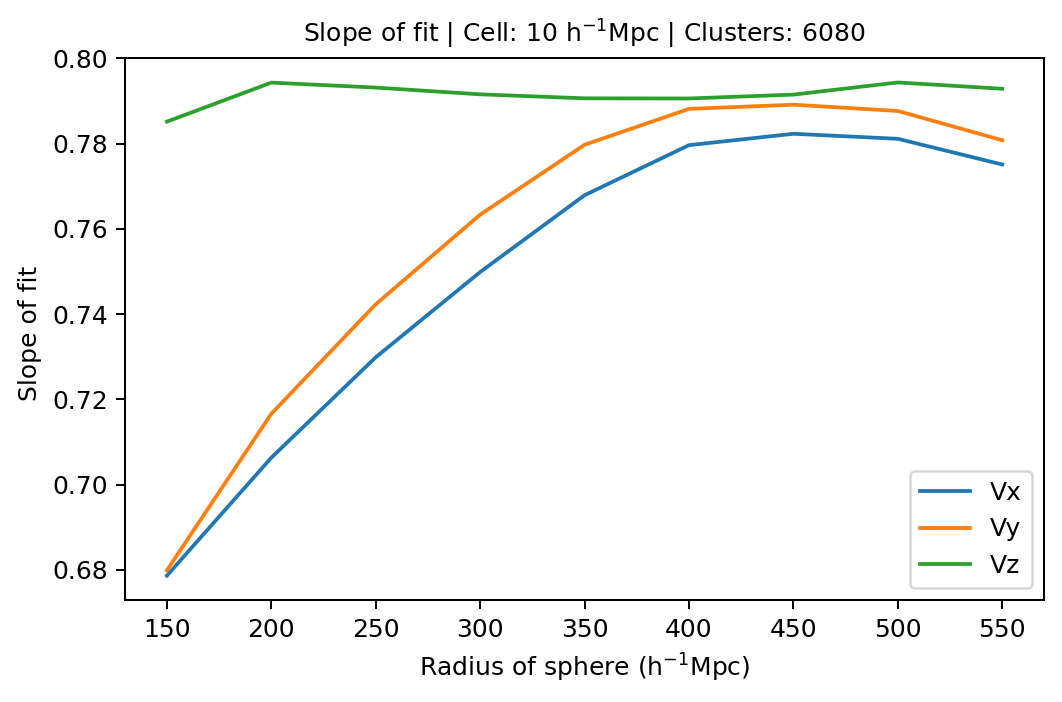

In [143]:
x_axis = np.arange(300000, 1200000, 100000)
x_axis = x_axis // 2e3

for cell_size in [10000]:
# for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:

    fig = plt.figure(dpi = dpi*2, facecolor=(1, 1, 1))
#     plt.subplot(121)
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['Slope - Vx'], 
             label = 'Vx')
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['Slope - Vy'], 
             label = 'Vy')
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['Slope - Vz'], 
             label = 'Vz')
    plt.legend()
    plt.xlabel(r'Radius of sphere (h$^{-1}$Mpc)')
    plt.ylabel('Slope of fit ')
#     plt.xticks(x_axis, [300000, 400000, 500000, 600000, 700000, 800000]//2e3)
#     plt.ylim(0,750)
    minus_one = {-1}
    no_of_clus = len(df_clusters_center)
    plt.title(r'Slope of fit | Cell: {} h$^{}$Mpc | Clusters: {}'.format(int(cell_size/1e3), minus_one, no_of_clus), fontsize = 10)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3)
    fig.savefig(f'Plots/big-sim-box/clus_bos_size_exam/cell_size_{cell_size}_slope.pdf')

#     plt.subplot(312)
#     plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vx'], label = 'Vx')
#     plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vy'], label = 'Vy')
#     plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vz'], label = 'Vz')
#     plt.legend()
#     plt.xlabel(r'Cube size (h$^{-1}$kpc)')
#     plt.ylabel('SD of V$_{\mathrm{est}}$ (km/s)')
#     plt.ylim(100, 1000)
#     plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
#     plt.title(r'SD of velocity | Cell: {} h$^{}$Mpc | Clusters: {}'.format(int(cell_size/1e3), minus_one, no_of_clus), fontsize = 10)

    fig = plt.figure(dpi = dpi*2, facecolor=(1, 1, 1))
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['r - Vx'], 
             label = 'Vx')
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['r - Vy'], 
             label = 'Vy')
    plt.plot(x_axis, 
             cube_cell_size_assess_no_round[cube_cell_size_assess_no_round['Cell Size'] == cell_size]['r - Vz'], 
             label = 'Vz')
    plt.legend(loc = 'lower right')
    plt.xlabel(r'Radius of sphere (h$^{-1}$Mpc)')
    plt.ylabel('Pearson\'s r')
#     plt.xticks(x_axis, [300000, 400000, 500000, 600000, 700000, 800000]//2e3)
    plt.ylim(0.70, 0.90)
    plt.title(r"Pearson's r | Cell: {} h$^{}$Mpc | Clusters: {}".format(int(cell_size/1e3), minus_one, no_of_clus), fontsize = 10)


    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3)
    fig.savefig(f'Plots/big-sim-box/clus_bos_size_exam/cell_size_{cell_size}_r.pdf')
#     plt.savefig(f'Plots/big-sim-box/clus_bos_size_exam/free_y_lim/cell_size_{cell_size}.png')
    plt.close()

**Finding the minimum value of mean & Sd, and maximum value of r**

In [27]:
print(cube_cell_size_assess['Mean - Vx'].abs().min())
print(cube_cell_size_assess['Mean - Vy'].abs().min())
print(cube_cell_size_assess['Mean - Vz'].abs().min())
print(cube_cell_size_assess['SD - Vx'].abs().min())
print(cube_cell_size_assess['SD - Vy'].abs().min())
print(cube_cell_size_assess['SD - Vz'].abs().min())
print(cube_cell_size_assess['r - Vx'].max())
print(cube_cell_size_assess['r - Vy'].max())
print(cube_cell_size_assess['r - Vz'].max())

8.8
8.8
8.4
189.3
178.0
189.7
0.84
0.84
0.85


**Conclusions**  
Similar to original simulation box, 
1. All three components of velocities behave similarly so anyone of them can be taken from now onwards as the line of sight velocity. Pearson's r is highest (0.85) for V$_\mathrm{z}$ so maybe prefer V$_\mathrm{z}$.
2. The code to estimate velocity seems to work fine since:  
(a) mean error in V$_\mathrm{x}$ goes to 6.7 km/s for cell size of 20,000 h$^\mathrm{-1}$kpc & cluster box size of 320,000 h$^\mathrm{-1}$kpc (SD is 179 km/s & r is 0.84 for this case)   
(b) standard deviation of error in V$_\mathrm{z}$ goes to 154 km/s for cell size of 10,000 h$^\mathrm{-1}$kpc & cluster box size of 320,000 h$^\mathrm{-1}$kpc (Mean is -38 km/s & r is 0.85 for this case)  
(c) Pearson's r goes to 0.85 for V$_\mathrm{z}$ estimates coming from cell size of 10,000 h$^\mathrm{-1}$kpc & cluster box size of 320,000 h$^\mathrm{-1}$kpc (Mean is -38 km/s & SD is 154 km/s for this case)
3. Cell size of 10,000 h$^\mathrm{-1}$kpc should be chosen since it gives least SD & maximum r.
4. Cluster box size does not make much difference but higher values do give a litter better mean, SD and r. A value of 320,000 h$^\mathrm{-1}$kpc may be choszen since it give r of 0.85.